In [76]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter, median_filter, convolve 
from skimage.morphology import opening, closing
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, estimate_sigma
from skimage.filters import threshold_local

## Pré Processamento

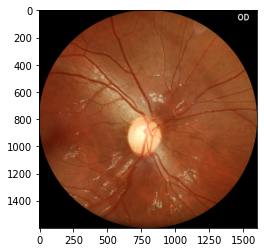

In [2]:
img = imageio.imread('images/4.jpg')
plt.imshow(img)

(1600, 1600)


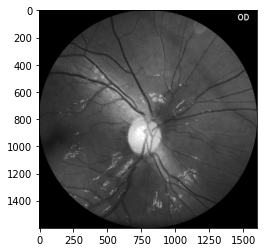

In [3]:
img_g = img[:,:,1]
print(img_g.shape)
plt.imshow(img_g,cmap='gray')

In [4]:
def filter_img(img, kernel_size=3, filter_type="mean"):
    pad = np.pad(img, kernel_size // 2, 'constant', constant_values=0)
    N, M = pad.shape
    
    a = b = int((kernel_size-1)/2)
    g = np.zeros(img.shape, dtype=np.uint8)
    
    if filter_type == "mean":
        weights = np.full((kernel_size, kernel_size), 1.0/(kernel_size**2))
        return convolve(img, weights=weights, mode="constant", cval=0)
    elif filter_type == "median":
        return median_filter(img, size=kernel_size)
    elif filter_type == "gaussian":
        return gaussian_filter(img, sigma=kernel_size)
    else:
        print('Error! Filter should be either mean or median!')
        return None

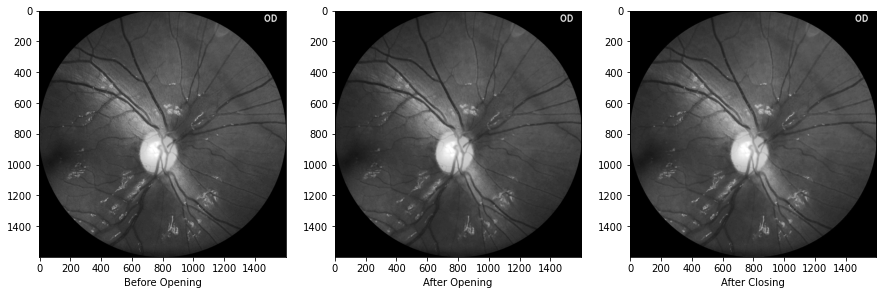

In [37]:
ker = np.array([[1,1,1],[1,1,1],[1,1,1]]).astype(np.uint8)
ker = np.ones((5, 5))
img_opening = opening(img_g, ker)
img_closing = closing(img_g, ker)

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.xlabel('Before Opening')
plt.imshow(img_g, cmap="gray")
plt.subplot(132)
plt.xlabel('After Opening')
plt.imshow(img_opening, cmap="gray")
plt.subplot(133)
plt.xlabel('After Closing')
plt.imshow(img_closing, cmap="gray")

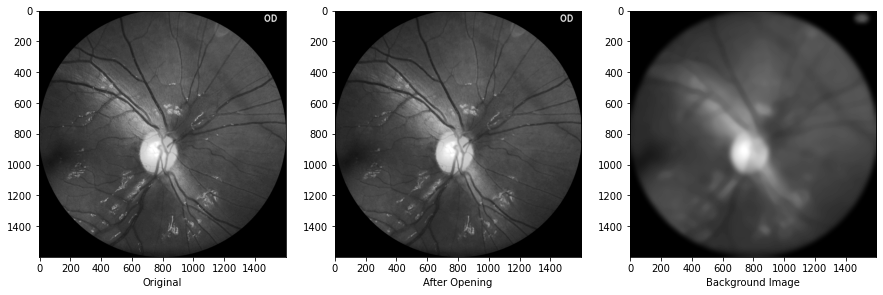

In [70]:
background = filter_img(img_opening, kernel_size=7, filter_type="mean")
background = filter_img(background, kernel_size=15, filter_type="gaussian")
background = filter_img(background, kernel_size=40, filter_type="median")

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.xlabel("Original")
plt.imshow(img_g, cmap="gray")
plt.subplot(132)
plt.xlabel("After Opening")
plt.imshow(img_opening, cmap="gray")
plt.subplot(133)
plt.xlabel("Background Image")
plt.imshow(background, cmap="gray")

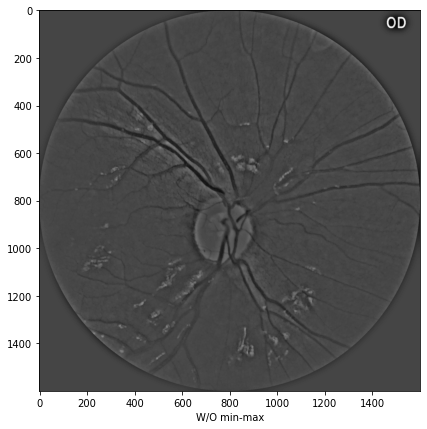

In [71]:
diff_img = img_opening.astype(np.int64) - background.astype(np.int64)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.xlabel("W/O min-max")
plt.imshow(diff_img, cmap="gray")

In [72]:
diff_img = ((diff_img - np.min(diff_img)) / (np.max(diff_img) - np.min(diff_img))*255).astype(np.uint8)
print(np.min(diff_img))
print(np.max(diff_img))

0
255


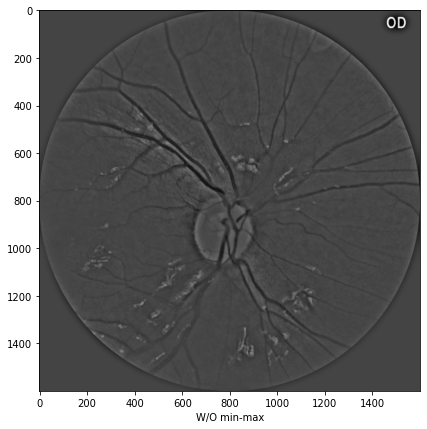

In [73]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.xlabel("W/O min-max")
plt.imshow(diff_img, cmap="gray")

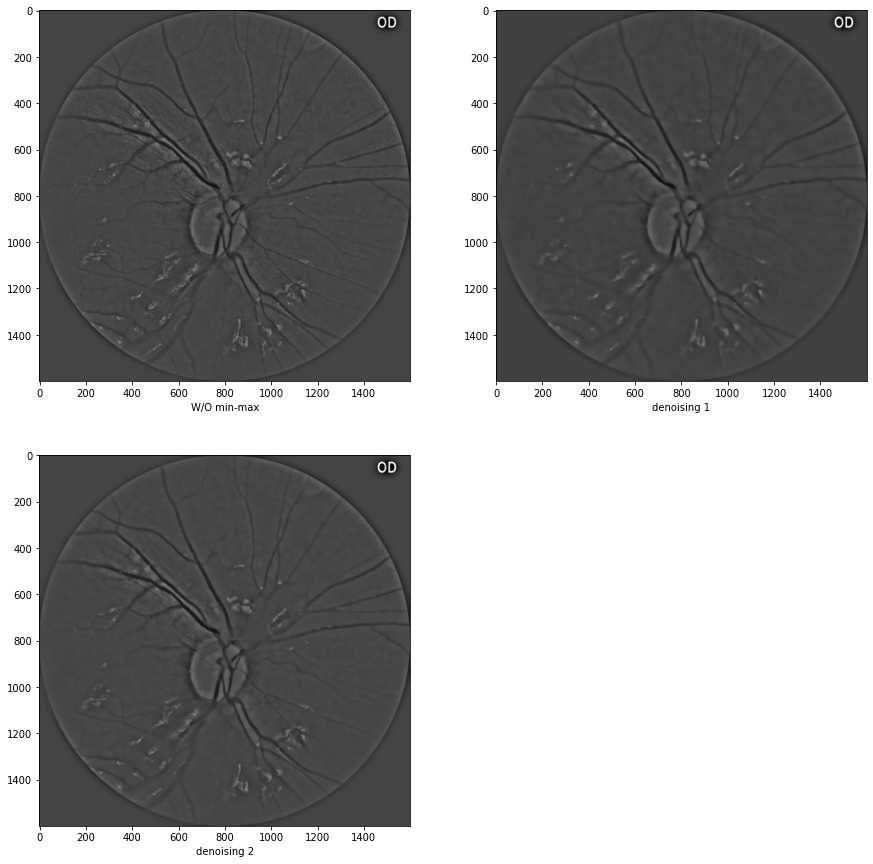

In [92]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.xlabel("W/O min-max")
plt.imshow(diff_img, cmap="gray")

# try to clean bg (gaussian maybe, to remove noise)
denoised_1 = denoise_tv_chambolle(diff_img, weight=0.15)
plt.subplot(222)
plt.xlabel("denoising 1")
plt.imshow(denoised_1, cmap="gray")

denoised_2 = denoise_tv_chambolle(diff_img, weight=0.05)
plt.subplot(223)
plt.xlabel("denoising 2")
plt.imshow(denoised_2, cmap="gray")

## Processamento

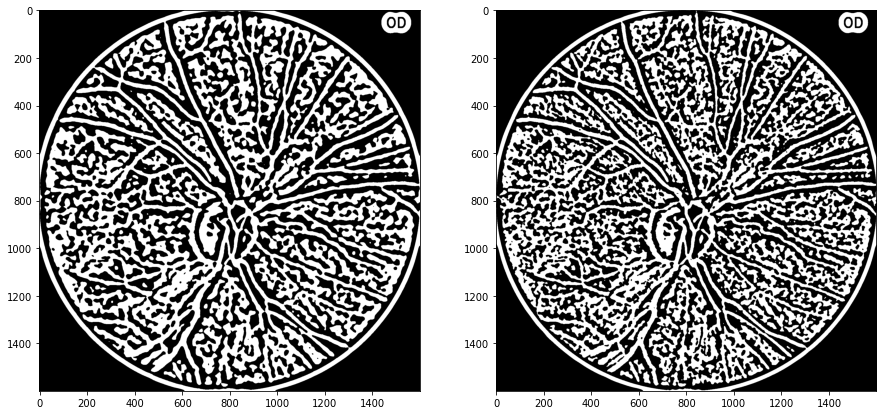

In [97]:
plt.figure(figsize=(15,15))

parameter = 10
block_size = 15
thresh_1 = threshold_local(denoised_1, block_size=block_size, method='gaussian', param=parameter)
thresh_img_1 = denoised_1 < thresh_1
thresh_2 = threshold_local(denoised_2, block_size=block_size, method='gaussian', param=parameter)
thresh_img_2 = denoised_2 < thresh_2

plt.subplot(121)
plt.imshow(thresh_img_1, cmap='gray')
plt.subplot(122)
plt.imshow(thresh_img, cmap='gray')